# Example Notebook to demonstrate the usage of the COCOScorer implementation

This example notebook demonstrates the use of the `COCOScorer` class to generate detection scores using the `COCO` and `COCOEval` APIs.

## Table Of Contents
* [Environment Setup](#environment-setup)
* [Sample input image and detections](#sample-input-image-and-detections)
* [Format and display GT detections](#format-and-display-gt-detections)
* [Load the model](#load-the-model)
* [Generate scores](#generate-scores)

## Environment Setup <a name="environment-setup"></a>

In [ ]:
import sys

print("Installing smqtk-detection centernet model")
!{sys.executable} -m pip install -qU smqtk-detection[centernet]

## Sample input image and detections <a name="sample-input-image-and-detections"></a>

For this notebook, we make use of a sample test image and COCO-format annotation file from the VisDrone dataset 


In [5]:
import os
import json
import urllib.request
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from PIL import Image
from smqtk_image_io.bbox import AxisAlignedBoundingBox

data_dir = './data'
os.makedirs(data_dir, exist_ok=True)

url = 'https://data.kitware.com/api/v1/item/623880f14acac99f429fe3ca/download'

img_path = os.path.join(data_dir, 'visdrone_img.jpg')
if not os.path.isfile(img_path):
    _ = urllib.request.urlretrieve(url, img_path)
img = np.asarray(Image.open(img_path))

json_filename = "sample.json"
with open(json_filename,"r") as f:
    gt = json.load(f)

## Format and display GT detections <a name="format-and-display-gt-detections"></a>

We convert the COCO annotations to the SMQTK format to make them compatible with the model and the scorer implementations.

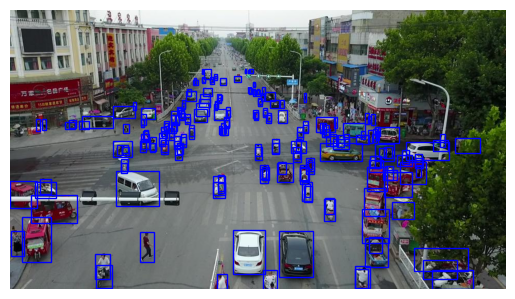

In [6]:
def format_detections(ann):
    minx, miny, w, h = ann['bbox']
    cat_id = ann['category_id']
    img_id = ann['image_id']
    return (AxisAlignedBoundingBox((minx, miny), (minx+w, miny+h)),
            {'category_id': cat_id, 'image_id': img_id})

gt_smqtk_format = []
for i in gt["annotations"]:
    formatted_gt = format_detections(i)
    gt_smqtk_format.append(formatted_gt)
    
fig, ax = plt.subplots()
ax.imshow(img)  # type: ignore
ax.set_axis_off()  # type: ignore
for gt_data in gt_smqtk_format:
    bbox = gt_data[0]
    width = bbox.max_vertex[0] - bbox.min_vertex[0]
    height = bbox.max_vertex[1] - bbox.min_vertex[1]

    ax.add_patch(Rectangle(  # type: ignore
                    (bbox.min_vertex[0], bbox.min_vertex[1]),
                    width,
                    height,
                    linewidth=1,
                    edgecolor='b',
                    facecolor='none'
                )) 
plt.show()

## Load the model <a name="load-the-model"></a>

We generate detections using SMQTK's custom `CenterNetVisdrone` model with `Resnet-50` weights.

In [7]:
from smqtk_detection.impls.detect_image_objects.centernet import CenterNetVisdrone

model_file = os.path.join(data_dir, 'centernet-resnet50.pth')
if not os.path.isfile(model_file):
    urllib.request.urlretrieve('https://data.kitware.com/api/v1/item/623259f64acac99f426f21db/download', model_file)

centernet_detector = CenterNetVisdrone(
    arch='resnet50',
    model_file='data/centernet-resnet50.pth',
    max_dets=500,
    use_cuda=False,
    batch_size=1,
    num_workers=1,
)

dets = list(centernet_detector([img]))[0]

## Generate scores <a name="generate-scores"></a>

We test the `COCOScorer` implementation by generating scores multiple times with randomly shuffled version of the predictions.

In [8]:
from nrtk.impls.score_detection.coco_scorer import COCOScorer
import random

scorer = COCOScorer(gt_path=json_filename, stat_index=0)
print(f"Categories list: {scorer.cat_ids}")

scores_list = scorer(actual=[gt_smqtk_format], predicted=[dets])  # type: ignore
print(f"Final COCO Eval score: {scores_list[0]}")

dets_shuffled_1 = random.sample(dets, k=len(dets))  # type: ignore
scores_list_shuffled_1 = scorer(actual=[gt_smqtk_format], predicted=[dets_shuffled_1])
print(f"Final COCO Eval score (after first random shuffle): {scores_list_shuffled_1[0]}")

dets_shuffled_2 = random.sample(dets, k=len(dets))  # type: ignore
scores_list_shuffled_2 = scorer(actual=[gt_smqtk_format], predicted=[dets_shuffled_2])
print(f"Final COCO Eval score (after second random shuffle): {scores_list_shuffled_2[0]}")

Categories list: {'pedestrian': 1, 'people': 2, 'bicycle': 3, 'car': 4, 'van': 5, 'truck': 6, 'tricycle': 7, 'awning-tricycle': 8, 'bus': 9, 'motor': 10}
Final COCO Eval score: 0.3519000565337795
Final COCO Eval score (after first random shuffle): 0.3519000565337795
Final COCO Eval score (after second random shuffle): 0.3519000565337795
